In [1]:
from exp.utils import *
from exp.models import *
from exp.losses import *
from tqdm.notebook import tqdm
from multiprocessing import Pool

import torch
import torch.nn as NN
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

In [2]:
seed = 92
seed_everything(seed)

In [3]:
model_name = "test_training_v1_pneumonia"
bs = 16
#epochs = 10
image_size = (228, 228)
device = get_device()
#lr = 3e-3
#sigmoid = NN.Sigmoid()
labels = get_labels()

Using the GPU!


In [4]:
train_df, valid_df, test_df = get_dataframes(include_labels=labels, small=True, small_fraction=0.1)
train_df.shape, valid_df.shape, test_df.shape

/home/favi/work/crx8/exp/utils.py:174: UserWarning: Train-Val-Split currently with patient overlap!
  warnings.warn("Train-Val-Split currently with patient overlap!")


((6921, 24), (1730, 24), (2559, 24))

In [5]:
train_label = train_df[labels].values
pos_weights = compute_positive_class_weigths(train_label)

In [6]:
train_tfs = transforms.Compose([
    transforms.Normalize([SUBSET_MEAN]*3, [SUBSET_STD]*3),
    #transforms.RandomHorizontalFlip(p=0.5)
])
test_tfs = transforms.Compose([
    transforms.Normalize([SUBSET_MEAN]*3, [SUBSET_STD]*3),
    
])

In [7]:
train_ds = CRX8_Data(train_df, get_image_path(), labels, image_size=image_size, transforms=train_tfs)
valid_ds = CRX8_Data(valid_df, get_image_path(), labels, image_size=image_size, transforms=test_tfs)
test_ds  = CRX8_Data(test_df , get_image_path(), labels, image_size=image_size, transforms=test_tfs)

In [8]:
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size=bs, shuffle=False)

dataloaders = {
    "train": train_dl,
    "val": valid_dl,
    "test": test_dl
}

In [9]:
criterion = NN.BCEWithLogitsLoss(reduction="mean", pos_weight=pos_weights.to(device))
#criterion = CustomLoss(reduction="sum", quadratic=False)

In [10]:
model = pretrained_densenet121(labels=labels)
model = model.to(device)

In [11]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [12]:
#model

In [12]:
model, transfer_optimizer = transfer_learn_setup(model, 1e-1)

In [14]:
#list(model.parameters())

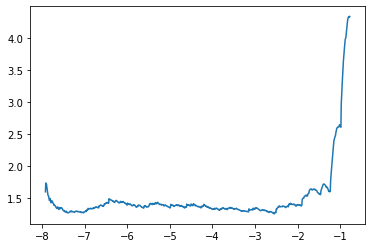

In [15]:
logs,losses = find_lr(model, train_dl, transfer_optimizer, criterion, device=device)
i = 10
plt.plot(logs[i:-i],losses[i:-i]);

In [16]:
lr = 3e-3
model = pretrained_densenet121(labels=labels)
model = model.to(device)

In [17]:
scheduler = get_one_cycle_scheduler(train_dl, lr, transfer_optimizer)

In [18]:
transfer_epochs = 5

In [19]:
model, history = fit(model, criterion, transfer_optimizer, 
                     scheduler, dataloaders, model_name,
                     transfer_epochs)

Epoch 1:


/home/favi/anaconda3/envs/crx8_pt/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "



Train: Loss: 1.357, Acc: 0.000, AUROC: 0.502



Val: Loss: 1.371, Acc: 0.000, AUROC: 0.509
Saved model with auroc 0.5085
Epoch 2:



Train: Loss: 1.357, Acc: 0.000, AUROC: 0.498



Val: Loss: 1.374, Acc: 0.000, AUROC: 0.505
Epoch 3:



Train: Loss: 1.358, Acc: 0.000, AUROC: 0.497



Val: Loss: 1.373, Acc: 0.000, AUROC: 0.506
Epoch 4:



Train: Loss: 1.358, Acc: 0.000, AUROC: 0.497



Val: Loss: 1.372, Acc: 0.000, AUROC: 0.509
Epoch 5:



Train: Loss: 1.356, Acc: 0.000, AUROC: 0.501



Val: Loss: 1.371, Acc: 0.000, AUROC: 0.508


In [ ]:
model = load_model(model_name)

In [ ]:
model, fine_optimizer = fine_tune_setup(model, lr)

In [ ]:
logs,losses = find_lr(model, train_dl, fine_optimizer, criterion, device=device)
i = 10
plt.plot(logs[i:-i],losses[i:-i]);

In [ ]:
lr = 1e-5
model = load_model(model_name)
model = model.to(device)

In [ ]:
scheduler = get_one_cycle_scheduler(train_dl, lr, fine_optimizer)

In [ ]:
fine_epochs = 50

In [ ]:
model, history = fit(model, criterion, fine_optimizer, 
                     scheduler, dataloaders, model_name,
                     fine_epochs)

In [ ]:
logger = Logger()
logger.add_metric("loss")
logger.add_metric("acc")
logger.add_metric("auroc")

In [ ]:
#for X, y in train_dl:
#    X, y = X.to(device), y.to(device)
#    preds = model(X)
#    loss = criterion(preds, y)
#    print(loss.item())

In [ ]:
#logs,losses = find_lr(model, train_dl, transfer_optimizer, criterion, device=device)
#i = 10
#plt.plot(logs[i:-i],losses[i:-i]);

In [ ]:
model = pretrained_densenet121(labels=labels)
model = model.to(device)

In [ ]:
transfer_optimizer = transfer_learn_setup(model, "densenet", lr)

In [ ]:
num_steps = len(train_dl)
lr_range = (lr / 10, lr)
scheduler = OneCycleLR(transfer_optimizer, num_steps, lr_range)

In [ ]:
model = train_model(model, criterion, transfer_optimizer, scheduler, 
                    dataloaders, logger, model_name, labels=labels,
                    num_epochs=3, device=device)

In [ ]:
logger.plot_losses()

In [ ]:
logger.plot_acc()

In [ ]:
logger.plot_auroc()

In [ ]:
lr = 1e-4

In [ ]:
fine_optimizer = fine_tune_setup(model, lr)
num_steps = len(train_dl)
lr_range = (lr / 10, lr)
scheduler = OneCycleLR(fine_optimizer, num_steps, lr_range)

In [ ]:
logger = Logger()
logger.add_metric("loss")
logger.add_metric("acc")
logger.add_metric("auroc")

In [ ]:
model = train_model(model, criterion, fine_optimizer, scheduler, 
                    dataloaders, logger, model_name, labels=labels,
                    num_epochs=epochs, device=device)

In [ ]:
logger.plot_losses()

In [ ]:
logger.plot_acc()

In [ ]:
logger.plot_auroc()

In [ ]:
#logs,losses = find_lr(model, train_dl, transfer_optimizer, criterion, device=device)
#i = 10
#plt.plot(logs[i:-i],losses[i:-i]);

In [ ]:
get_working_dir().ls()

In [ ]:
get_model_path()/model_name

In [ ]:
model, history = fit(model, 
        criterion, 
        fine_optimizer, 
        scheduler, 
        dataloaders, 
        model_name, 
        1)

In [ ]:
#valid_dl

In [ ]:
d = validate(model, 
             criterion, 
             valid_dl, 
             model_name)

In [ ]:
d[0], d[1], d[3]

In [ ]:
np.array(list(d[-2].values()))

In [ ]:
d[-1].shape

In [ ]:
scheduler.reset()
model, hist = train_one_cycle(model, 
                    criterion, 
                    fine_optimizer, 
                    scheduler, 
                    train_dl, 
                    logger, 
                    model_name)

In [ ]:
y, y_hat = np.array(hist["y"]), np.array(hist["y_hat"])

In [ ]:
auroc_score(y_hat, y, model_name)[0][model_name].mean()